In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit


import copy
import numpy as np
import scipy as scy

In [73]:
class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.
        """
        self.box_size = box_size
        self.particles_pos = np.zeros((n_Particles,2))
        self.particles_vel = np.zeros((n_Particles,2))
        self.particles_acc = np.zeros((n_Particles,2))

        self.particles_r = np.zeros(n_Particles)
        self.particles_m = np.zeros(n_Particles)

        self.n_particles = n_Particles


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")

    def random_positions(self, axis, n_particles = 0):
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2)):
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed
        x,y         : initial positions as array of length n; default random positions 0.5 away from border
        """
        
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass


        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
            
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel
        
        if align == 'random':
            if len(x) == 0:
                self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            if len(y) == 0:
                self.particles_pos[:,1] = self.random_positions(1,self.n_particles)
        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                self.particles_pos[:,0] = np.linspace(0,self.box_size[0],num=grid[0])
                self.particles_pos[:,1] = np.linspace(0,self.box_size[1],num=grid[1])
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
    
    def move(self, dt = 1., vel = []):
        """moving the particle in the direction, where the velocity-vector points.\n
        dt  : the time-step moving forward; default = 1\n
        vel : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        """
        if len(vel) == 0:
            vel = self.particles_vel
        self.particles_pos += vel*dt

    
    def wrap_around(self):
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size

    def reflect(self):
        """Reflecting particles on the edges of the box.\n
        particles   : Particles, which should be reflected; default self.particles\n
        returns     : array of particles with new positions
        """
        top = np.where(self.particles_pos+self.particles_r > self.box_size)
        bottom = np.where(self.particles_pos-self.particles_r < 0)
        self.particles_vel[top] *= -1
        self.particles_vel[bottom] *= -1

    def calculate_distance_matrix(self):
        distance_mat = np.abs(self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :])
        overlimit = np.where(distance_mat[:, :] > (0.5 * self.box_size))#, np.abs(self.box_size - distance_mat[:, :]), distance_mat[:, :])
        print(overlimit)
        return distance_mat
    

In [74]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps, dt):
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.set_traj()

    def set_traj(self):
        """Initialize the trajectory-saving"""
        self.data_traj  = np.zeros((self.box.n_particles, 6, self.steps+1))
        self.pot_energy = np.zeros((self.steps+1, self.box.n_particles, self.box.n_particles))
        self.kin_energy = np.zeros((self.steps+1, self.box.n_particles))

    




In [75]:
box = Box(np.array([5,5]),49)


In [76]:
box.fill_particles(0.5,18,150)

In [79]:
print(box.particles_pos[np.newaxis, :, :])
print(box.particles_pos[:, np.newaxis, :])

[[[2.66006947e+00 1.86303988e+00]
  [1.73747799e+00 4.25067307e+00]
  [2.83301220e+00 1.94677008e+00]
  [2.61979595e+00 4.16351224e+00]
  [3.86350620e-01 1.69162541e+00]
  [1.11970509e+00 2.28399554e+00]
  [4.03943062e+00 1.90898470e-03]
  [2.03447325e+00 2.93322320e+00]
  [8.95369303e-01 1.68711726e+00]
  [1.23914144e-01 2.15506350e+00]
  [2.64365374e+00 2.45055376e+00]
  [1.13801897e+00 3.52539057e+00]
  [4.30307471e+00 1.39986445e+00]
  [2.94410717e+00 3.17778248e+00]
  [1.41632754e+00 1.77384389e+00]
  [2.13197354e+00 8.71879011e-01]
  [1.59636366e+00 2.38322086e-01]
  [1.42751936e+00 2.83661696e+00]
  [3.11855086e+00 2.09803780e+00]
  [4.96485368e-01 2.91241913e+00]
  [1.40868306e+00 3.25149657e+00]
  [4.24638353e+00 3.25725227e+00]
  [4.27303712e-01 4.08017982e-01]
  [2.01936803e-02 3.71092219e+00]
  [3.75248093e-01 1.13188144e+00]
  [1.76344483e+00 2.31717291e+00]
  [1.79774359e+00 2.82132925e+00]
  [3.76104718e+00 1.78196658e+00]
  [3.71705617e+00 2.24270426e+00]
  [2.91085111e

In [77]:
box.calculate_distance_matrix()

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 1

array([[[0.        , 0.        ],
        [0.92259148, 2.38763319],
        [0.17294273, 0.0837302 ],
        ...,
        [1.45922861, 2.04647858],
        [1.67144378, 2.18313052],
        [0.96941301, 0.14103002]],

       [[0.92259148, 2.38763319],
        [0.        , 0.        ],
        [1.09553421, 2.30390299],
        ...,
        [2.38182009, 0.34115461],
        [2.59403526, 0.20450267],
        [1.8920045 , 2.52866321]],

       [[0.17294273, 0.0837302 ],
        [1.09553421, 2.30390299],
        [0.        , 0.        ],
        ...,
        [1.28628588, 1.96274838],
        [1.49850104, 2.09940032],
        [0.79647028, 0.22476022]],

       ...,

       [[1.45922861, 2.04647858],
        [2.38182009, 0.34115461],
        [1.28628588, 1.96274838],
        ...,
        [0.        , 0.        ],
        [0.21221517, 0.13665194],
        [0.48981559, 2.1875086 ]],

       [[1.67144378, 2.18313052],
        [2.59403526, 0.20450267],
        [1.49850104, 2.09940032],
        .

In [58]:
box.particles_pos[0]-box.particles_pos[1]

array([ 2.61291467, -1.41731398])

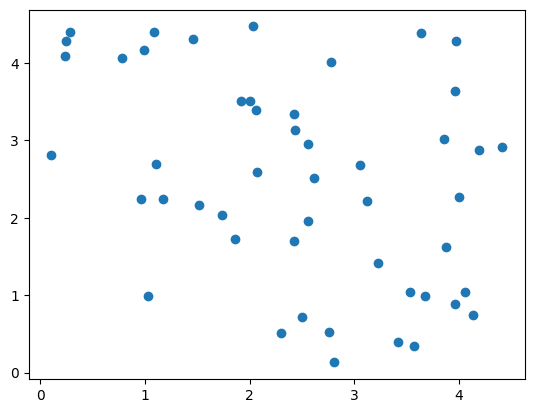

In [56]:
plt.scatter(box.particles_pos[:,0],box.particles_pos[:,1])

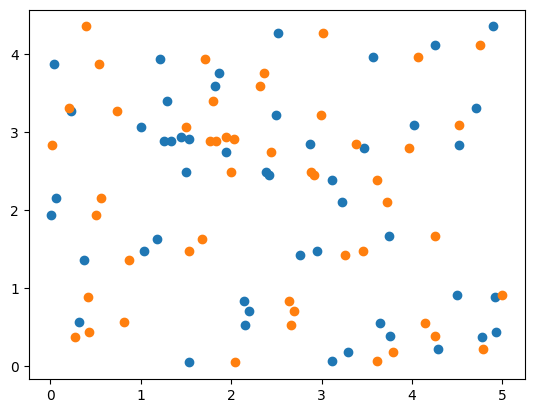

In [37]:
plt.scatter(box.particles_pos[:,0],box.particles_pos[:,1])
box.particles_pos[:,0] = box.particles_pos[:,0]+0.5
box.wrap_around()
plt.scatter(box.particles_pos[:,0],box.particles_pos[:,1])

In [20]:
print(box.particles_pos)
print(box.particles_vel)
print(box.particles_acc)

print(box.particles_r)
print(box.particles_m)

[[3.09695972 3.65716625]
 [0.18209364 0.58151068]
 [4.02489861 1.9205631 ]
 [1.02242528 1.68743336]
 [1.27346177 0.45613879]
 [0.02831546 0.50567607]
 [0.41341574 2.02930306]
 [0.50477556 1.1061694 ]
 [2.10792016 3.78935947]
 [3.10801845 1.29614309]
 [3.39689972 2.66886329]
 [3.64870675 0.66500822]
 [2.56765985 0.17461758]
 [2.80396087 3.45078161]
 [4.25688946 4.38658091]
 [4.14137422 0.91048753]
 [1.27977164 1.92813764]
 [0.41745583 2.01746256]
 [1.36632421 4.08336006]
 [1.72757517 4.46101652]
 [3.84597926 3.11320607]
 [0.26417515 3.38775477]
 [1.95483884 0.57635025]
 [1.77770537 1.80439316]
 [2.17339502 1.65573705]
 [2.83352889 0.20159079]
 [2.76142493 3.65763135]
 [2.35951932 3.75176969]
 [3.84681841 4.26549589]
 [4.36766626 4.19484209]
 [0.44589046 4.18180131]
 [3.25076135 2.95288735]
 [2.90956986 3.87580385]
 [2.36573188 0.35231239]
 [3.78456639 2.6558748 ]
 [2.7507913  2.30622958]
 [2.29817077 2.39969877]
 [2.10997723 2.80641423]
 [1.04014261 2.89962432]
 [1.31567712 1.69810786]
